In [41]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join
import matplotlib.pyplot as plt
import seaborn as sns
import random


from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


### Leitura dos dados

In [42]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 


def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

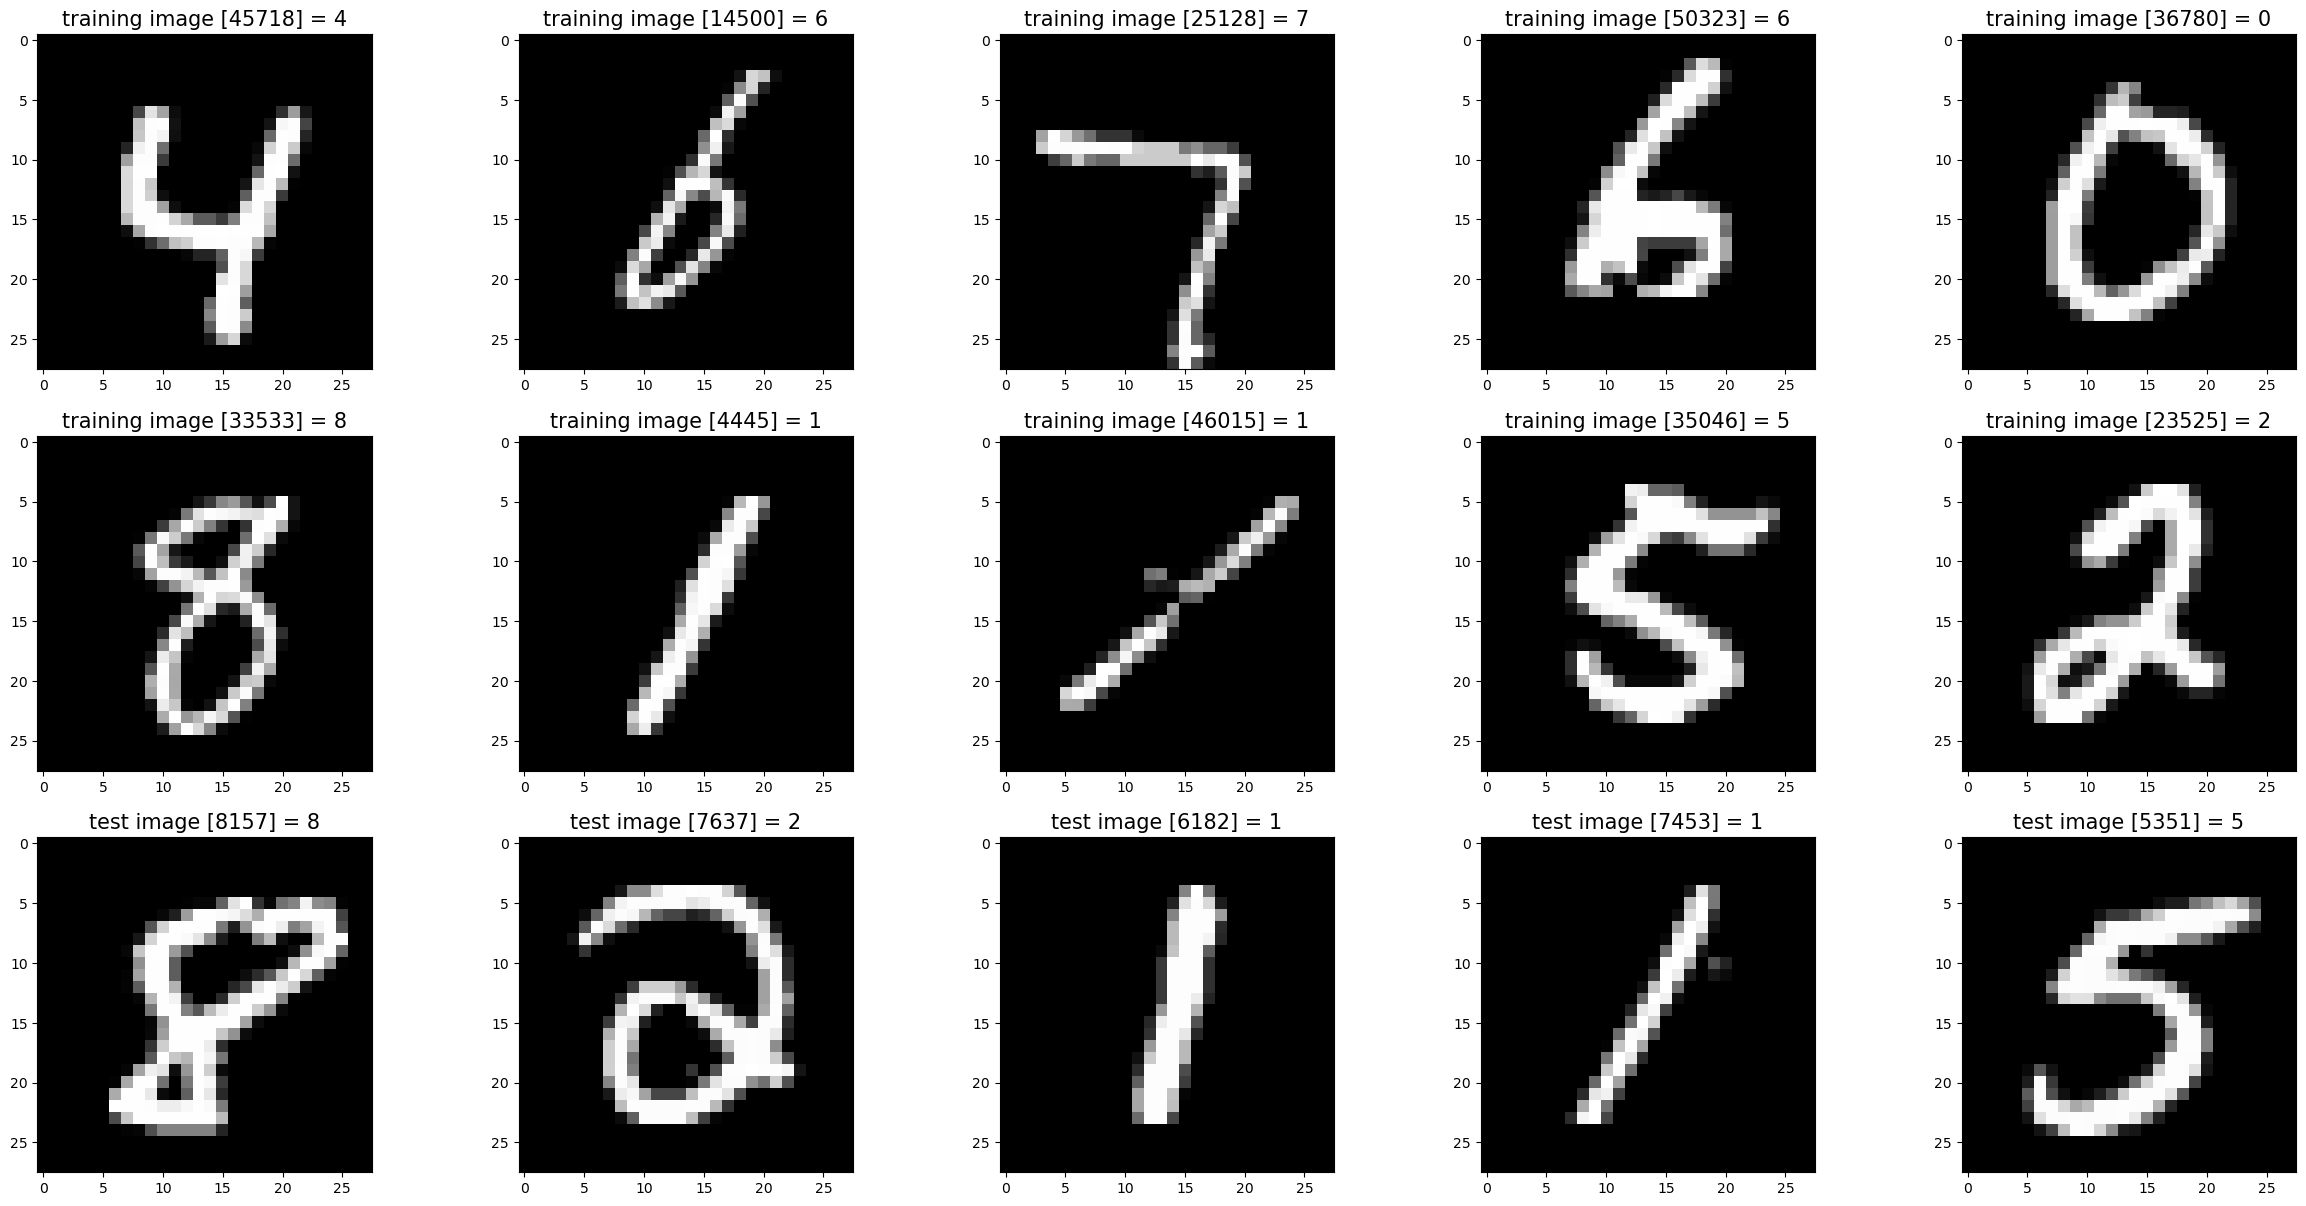

In [43]:
input_path = 'archive'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')


#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

### Separando em treino e validação, e normalizando os dados

In [44]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = np.array(x_test).astype('float32') / 255.0


y_test_one_hot = to_categorical(y_test, 10)
y_train_one_hot = to_categorical(y_train, 10)
y_val_one_hot = to_categorical(y_val, 10)

### Criação da rede

In [45]:
# verificando o número de neurônios na camada oculta necessários
num_neuronios = int((x_train.shape[0] - 10)/(10*(x_train.shape[1] + 2)))
print(x_train.shape[0], x_train.shape[1], num_neuronios)

48000 28 159


In [46]:

model = Sequential([
    Flatten(input_shape=(28, 28)),  # Ajuste aqui o formato dos dados
    Dense(90, activation='selu'),
    Dense(60, activation='selu'),
    Dense(10, activation='softmax')
])

# Compilar o modelo com sparse_categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


c:\Users\ivoar\anaconda3\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 90)             │        70,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 60)             │         5,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,720 (299.69 KB)

 Trainable params: 76,720 (299.69 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# para o treinamento caso a rede não melhore após 20 épocas
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

history = model.fit(x_train, y_train_one_hot, validation_data=(x_val, y_val_one_hot), epochs=100, batch_size=256, verbose=1, callbacks=[es])

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7649 - loss: 0.7698 - val_accuracy: 0.9232 - val_loss: 0.2691
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9272 - loss: 0.2523 - val_accuracy: 0.9398 - val_loss: 0.2063
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9438 - loss: 0.1972 - val_accuracy: 0.9489 - val_loss: 0.1718
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9536 - loss: 0.1590 - val_accuracy: 0.9526 - val_loss: 0.1544
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9617 - loss: 0.1350 - val_accuracy: 0.9609 - val_loss: 0.1341
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9659 - loss: 0.1139 - val_accuracy: 0.9628 - val_loss: 0.1253
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9715 - loss: 0.0990 - val_accuracy: 0.9667 - val_loss: 0.1145
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9751 - loss: 0.0851 - val_accu

--> Acuracia (validacao): 0.9748


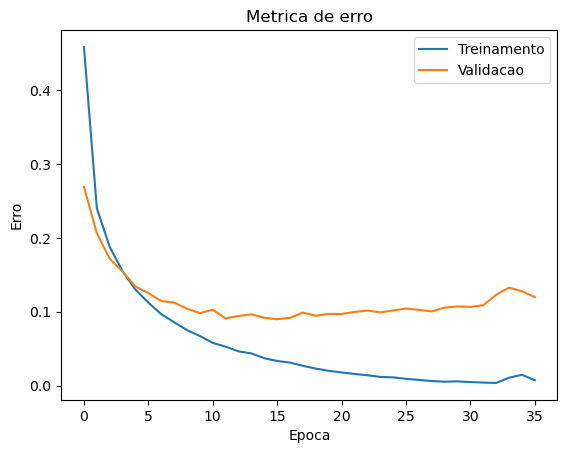

In [48]:
 # Avalia o modelo
  # Avalia o modelo
_, accuracy_val = model.evaluate(x_val, y_val_one_hot, batch_size=32, verbose=0)
print(f'--> Acuracia (validacao): {accuracy_val:.4f}')

# Exibe o historico de treinamento para um fold especifico
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'], loc='upper right')
plt.show()

--> Acuracia (teste): 0.9757
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


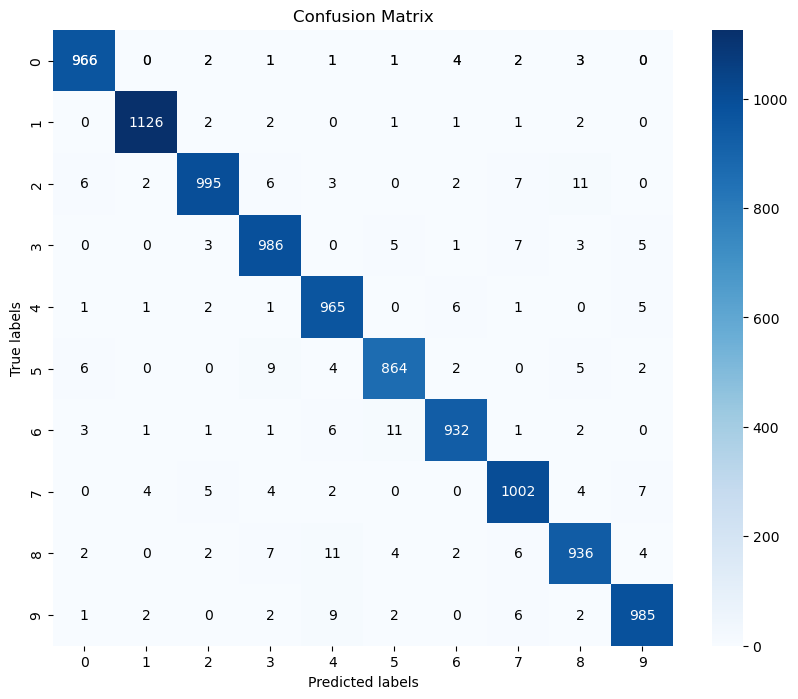

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.96      0.98      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [49]:
# avalia no conjunto de teste
_, accuracy_test = model.evaluate(x_test, y_test_one_hot, batch_size=32, verbose=0)
print(f'--> Acuracia (teste): {accuracy_test:.4f}')


y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# coloca o numero em cada celula da matriz
for i in range(10):
    for j in range(10):
        if i == j:
            plt.text(j+0.5, i+0.5, cm[i, j], ha='center', va='center', color='white')
        else:
            plt.text(j+0.5, i+0.5, cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))